## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

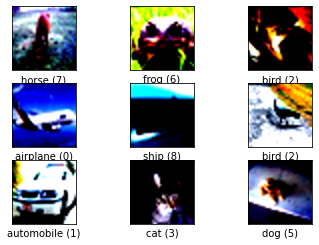

torch.Size([9, 3, 32, 32])


In [4]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

        print(np.shape(images))

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

In [5]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        # size of input = [64 x 3 x 32 x 32]

        self.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=32, kernel_size=5, stride=1, padding=0, dilation=1)  # w1 = (32 x 3 x 5 x 5), b1 = (32 x 1)
        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0, dilation=1) # w2 = (64 x 32 x 5 x 5), b2 = (64 x 1)
        self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=1200)
        self.fc2 = nn.Linear(in_features=1200, out_features=n_output)
      
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        
        # x = (64 x 3 x 32 x 32)
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = self.bn1(x)
        # conv1 => x = (64 x 32 x 28 x 28), max_pool2d => x = (64 x 32 x 14 x 14), relu => x = (64 x 32 x 14 x 14)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = self.bn2(x)
        # conv2 => x = (64 x 64 x 10 x 10), max_pool2d => x = (64 x 64 x 5 x 5), relu => x = (64 x 64 x 5 x 5)
        x = F.relu(self.fc1(x.view(-1, 64 * 5 * 5)))
        # view => x = (64 x 1600), fc1 => x = (64 x 1200), relu => x = (64 x 1200)
        x = self.fc2(x)
        # fc2 => x = (64 x 10)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [6]:
# Try to overfit one batch of the training set
net = ConvNet()

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-1)

# get one batch of the training set
data_iter = iter(trainloader)
images, labels = data_iter.next()

epochs = 15
for e in range(epochs):
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    # Compute the accuracy on the validation set to compare
    total = 0
    correct = 0
    for ii, (images_val, labels_val) in enumerate(valloader):
        outputs = net(images_val)
        _, predicted = torch.max(F.softmax(outputs).data, 1)

        total += labels_val.size(0)                       # Total images
        correct += (predicted == labels_val).sum().item() # Total correct classified images
    accuracy = 100*correct/total     # accuracy over the images of the validation set

    # Compute the accuracy on the training set
    _, predicted_train = torch.max(F.softmax(output).data, 1)
    total_train = labels.size(0)                             # Total images
    correct_train = (predicted_train == labels).sum().item() # Total correct classified images
    accuracy_train = 100*correct_train/total_train

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training accuracy: {:.2f}%..".format(accuracy_train),
          "Validation accuracy: {:.2f}%..".format(accuracy)
         )


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/15.. Training accuracy: 10.94%.. Validation accuracy: 16.20%..
Epoch: 2/15.. Training accuracy: 65.62%.. Validation accuracy: 18.50%..
Epoch: 3/15.. Training accuracy: 81.25%.. Validation accuracy: 18.50%..
Epoch: 4/15.. Training accuracy: 81.25%.. Validation accuracy: 19.10%..
Epoch: 5/15.. Training accuracy: 90.62%.. Validation accuracy: 20.80%..
Epoch: 6/15.. Training accuracy: 96.88%.. Validation accuracy: 18.40%..
Epoch: 7/15.. Training accuracy: 96.88%.. Validation accuracy: 20.10%..
Epoch: 8/15.. Training accuracy: 100.00%.. Validation accuracy: 19.10%..
Epoch: 9/15.. Training accuracy: 100.00%.. Validation accuracy: 20.30%..
Epoch: 10/15.. Training accuracy: 100.00%.. Validation accuracy: 20.50%..
Epoch: 11/15.. Training accuracy: 100.00%.. Validation accuracy: 19.40%..
Epoch: 12/15.. Training accuracy: 100.00%.. Validation accuracy: 20.40%..
Epoch: 13/15.. Training accuracy: 100.00%.. Validation accuracy: 20.00%..
Epoch: 14/15.. Training accuracy: 100.00%.. Validation

In [7]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.CrossEntropyLoss()
learning_rate_start = 1e-1 # [1e-1, 2e-1]

epochs = 5
steps = 0
print_every = 20

# coefficients for regularization using L2 and L1 penalty
lambda_l2 = 0.005  # 0, 0.001, 0.005, 0.01
lambda_l1 = 0.0   # 0.000001, 0.000005, 0.00001 

# store loss and accuracy for training and validation set
loss_history_training = []
loss_history_validation = []
accuracy_history_training = []
accuracy_history_validation = []
running_loss_training = 0
running_loss_validation = 0
total_training = 0
correct_training = 0
total_validation = 0
correct_validation = 0

# configure learning rate decay
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate_start)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

# go through the training set e times
for e in range(epochs):
    print("\n lr = {:e}:".format(scheduler.get_last_lr()[0]))
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        
        optimizer.zero_grad() # set the gradient of the parameters to zero through the optimizer
        output = net(images)

        _, predicted_training = torch.max(F.softmax(output).data, 1)

        # update variables for accuracy on training set
        total_training += labels.size(0)                                # Total images
        correct_training += (predicted_training == labels).sum().item() # Total correct classified images

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, labels)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
                
        # L2 penalty term (to avoid overfitting the training data for an increasing number of epochs)
        for p in net.parameters():
            loss += lambda_l2 * p.pow(2).sum()
                
        loss.backward()
        optimizer.step()

        # L1 penalty (directly changes the parameters in the network)
        with torch.no_grad():
            for p in net.parameters():
                p.sub_(p.sign() * p.abs().clamp(max = lambda_l1))

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss_training += loss.item()

        if steps % print_every == 0:
            stop = time.time()
            # reset training and validation accuracy after print_every iterations
            accuracy_training = 0
            accuracy_validation = 0
            for ii, (images, labels) in enumerate(valloader):
                
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                outputs = net(images)
                _, predicted_validation = torch.max(F.softmax(outputs).data, 1)

                # Loss for validation set
                loss_validation = criterion(outputs, labels)

                # L2 penalty term
                for p in net.parameters():
                    loss_validation += lambda_l2 * p.pow(2).sum()
                
                running_loss_validation += loss_validation.item()

                # update variables for accuracy on validation set
                total_validation += labels.size(0)                                  # Total images
                correct_validation += (predicted_validation == labels).sum().item() # Total correct classified images

            # compute accuracy for training and validation set
            accuracy_training = 100*correct_training/total_training
            accuracy_validation = 100*correct_validation/total_validation
            
            # store loss and accuracy for training and validation set
            loss_history_training.append(running_loss_training/print_every) # mean loss on training set over print_every iterations
            loss_history_validation.append(running_loss_validation/(ii+1))  # mean loss on validtion set, updated all print_every iterations
            accuracy_history_training.append(accuracy_training)
            accuracy_history_validation.append(accuracy_validation)

            ################################################################################
            #                              END OF YOUR CODE                                #
            ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Training Loss: {:.4f}..".format(running_loss_training/print_every),
                  "Validation Loss: {:.4f}..".format(running_loss_validation/(ii+1)),
                  "Training accuracy: {:.2f}%..".format(accuracy_training),
                  "Validation accuracy: {:.2f}%..".format(accuracy_validation),            # accuracy over the images of the validation set
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            # reset variables for training and validation loss after print_every iterations
            running_loss_training = 0
            running_loss_validation = 0
            # reset variables for training and validation accuracy after print_every iterations
            total_training = 0
            correct_training = 0
            total_validation = 0
            correct_validation = 0

            start = time.time()

    # decrease learning rate
    scheduler.step()



 lr = 1.000000e-01:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/5.. Training Loss: 4.5826.. Validation Loss: 4.4108.. Training accuracy: 26.95%.. Validation accuracy: 32.30%.. 0.1535 s/batch
Epoch: 1/5.. Training Loss: 4.2797.. Validation Loss: 4.2727.. Training accuracy: 36.64%.. Validation accuracy: 34.90%.. 0.1381 s/batch
Epoch: 1/5.. Training Loss: 4.0634.. Validation Loss: 3.9756.. Training accuracy: 39.45%.. Validation accuracy: 43.00%.. 0.1360 s/batch
Epoch: 1/5.. Training Loss: 3.9356.. Validation Loss: 3.8150.. Training accuracy: 42.58%.. Validation accuracy: 45.30%.. 0.1368 s/batch
Epoch: 1/5.. Training Loss: 3.7699.. Validation Loss: 3.7774.. Training accuracy: 45.31%.. Validation accuracy: 43.70%.. 0.1410 s/batch
Epoch: 1/5.. Training Loss: 3.7058.. Validation Loss: 3.6408.. Training accuracy: 43.28%.. Validation accuracy: 45.20%.. 0.1384 s/batch
Epoch: 1/5.. Training Loss: 3.5281.. Validation Loss: 3.5195.. Training accuracy: 49.14%.. Validation accuracy: 47.40%.. 0.1367 s/batch
Epoch: 1/5.. Training Loss: 3.5056.. Validation 

In [8]:
# Plot settings
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

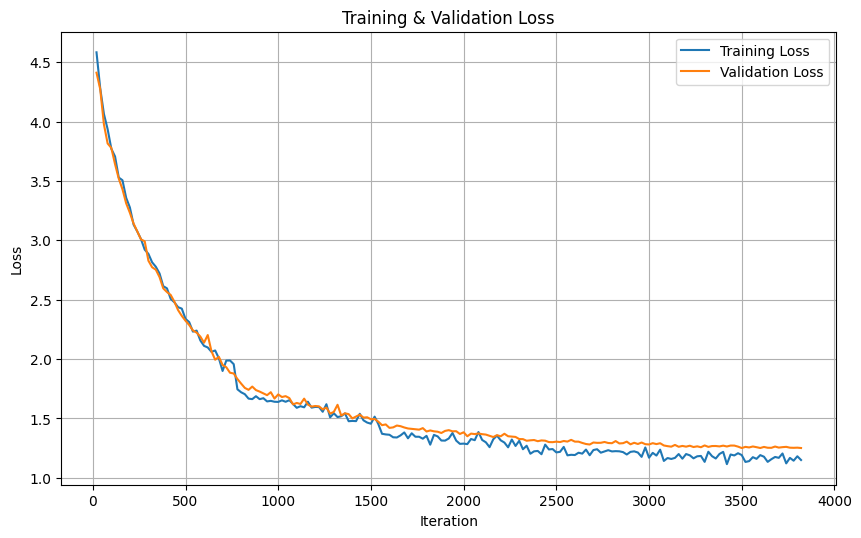

In [9]:
# Plotting the loss history for different learning rates
plt.plot((np.arange(np.shape(loss_history_training)[0])+1)*print_every, loss_history_training, label='Training Loss')
plt.plot((np.arange(np.shape(loss_history_validation)[0])+1)*print_every, loss_history_validation, label='Validation Loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(bbox_to_anchor = (1, 1))
plt.grid()
plt.show() # Load the display window

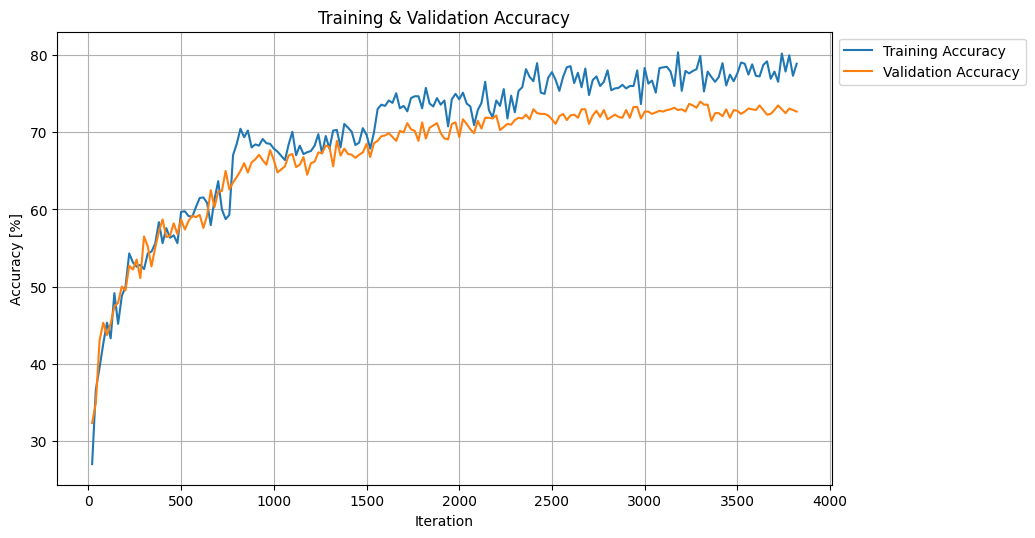

In [10]:
# Plotting the loss history for different learning rates
plt.plot((np.arange(np.shape(accuracy_history_training)[0])+1)*print_every, accuracy_history_training, label='Training Accuracy')
plt.plot((np.arange(np.shape(accuracy_history_validation)[0])+1)*print_every, accuracy_history_validation, label='Validation Accuracy')
plt.xlabel("Iteration")
plt.ylabel("Accuracy [%]")
plt.title("Training & Validation Accuracy")
plt.legend(bbox_to_anchor = (1, 1))
plt.grid()
plt.show() # Load the display window

Save best trained model.

In [11]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)

torch.save(net.state_dict(), 'drive/MyDrive/Colab Notebooks/tp_3/ConvNN.ckpt')

In [12]:
checkpoint = torch.load("drive/MyDrive/Colab Notebooks/tp_3/ConvNN.ckpt")
net.load_state_dict(checkpoint)

<All keys matched successfully>